In this post I want to apply clustering to ETFs to determine the most effective diversified portfolio. There are a lot of ETFs out there, in my database I count 3612, included delisted ones. If I wanted to build a simple, well-diversified portfolio to hold long-term, which ones should I pick? Would I do better with an S&P 500 ETF or a total stock market ETF? What kind of bond ETFs provide the most diversification to a portfolio? Clustering can help to answer these kinds of questions.

# Data

I'm immedicately going to introduce one simplificaiton to this problem, which is to restrict which tickers are analyzed. Firstly, I'm going to use only ETFs that have price histories before the 2008 crash in September. Secondly, I'm going to make some stylistic choices. I like Vanguard, so I'm including all of their ETFs that meet the date criteria. However, there are some asset groups they don't offer ETFs for, so I'm also including some iShares ETFs to fill the gaps for things like real estate and junk bonds.

In total, this brings the total to 31 tickers, which is a far cry from how many I *could* include. This makes the results much easier to interpret and more practical.

In [1]:
import psycopg2 as pg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AffinityPropagation
from sklearn.covariance import GraphicalLassoCV
from sklearn.manifold import LocallyLinearEmbedding

from config import DATABASE_URI

plt.rcParams["figure.figsize"] = (15,10)

In [4]:
# All vanguard funds plus HYG, EMB, IYR, and SPY for junk bonds, emerging markets bonds, real estate, and the S&P 500
# respectively.
# All created before the 2008 crash, IE before september 29 2008
tickers = ["EDV", "BIV", "BLV", "BSV", "BND", "VIG", "VUG", "VYM", "VV", "MGC", "MGK", "MGV", "VTI", "VTV",
           "VXF", "VO", "VOT", "VOE", "VB", "VBK", "VBR", "VT", "VEU", "VEA", "VGK", "VPL", "VWO",
           "HYG", "EMB", "IYR", "SPY"]
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute(f"SELECT date, ticker, closeadj FROM prices WHERE ticker IN {tuple(tickers)}")
        results = cur.fetchall()

In [6]:
df = pd.DataFrame.from_records(results, columns=["date", "ticker", "closeadj"], coerce_float=True)
# Set index, sort index, then transform into Series via squeeze
df = df.set_index(["date", "ticker"], verify_integrity=True).sort_index().squeeze()

In [7]:
returns = df.unstack().pct_change().dropna()

# Estimating Structure

Alright, so now I have a big matrix of daily returns for 31 different ETFs, what can we say about their structure? An obvious way to look at this is by calculating a covariance matrix. However, this problem brings some challenges here. Luckily, because of the length of the data, I don't have to worry about the number of features being larger than the number of data points.

The problem really is that estimating the empirical covariance matrix doesn't do well at uncovered *structure*. What I'm looking for is a graphical model that links together the ETFs we have. I want to know which are meaningfully correlated with which others and which have no meaningful correlation. An empirical covariance matrix will mostly say everything is at least a little correlated with everything else. Which while may be true, isn't useful for what I want to do.

What I need is a *sparse* covariance matrix. When two tickers don't have much to do with each other, I want that covariance value to be zero. This is what a Graphical Lasso will do. Exactly as in Lasso-regularized regression, this procedure shrinks values towards zero.

In [37]:
# Standardizing improves estimation of sparse covariance matrix
X = returns.values.copy()
X /= X.std(axis=0)

edge_model = GraphicalLassoCV().fit(X)

/home/eadains/EquitiesTrading/venv/lib/python3.8/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


Text(0.5, 1.0, 'Normal Covariance')

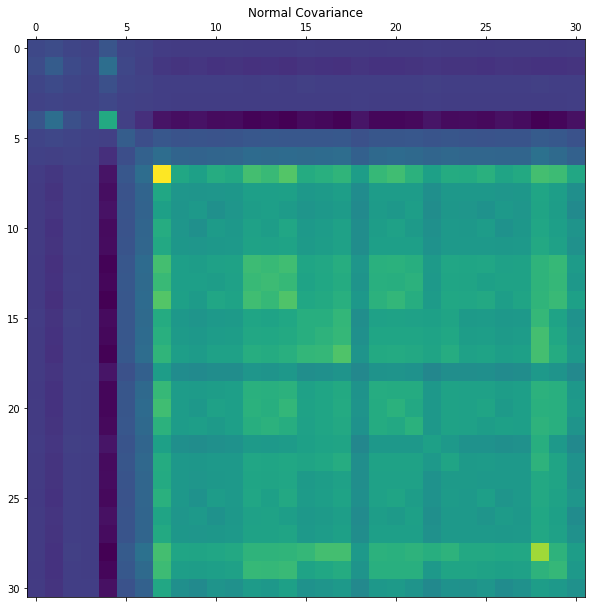

In [38]:
plt.matshow(np.cov(returns.T))
plt.title("Normal Covariance")

Text(0.5, 1.0, 'Sparse Covariance')

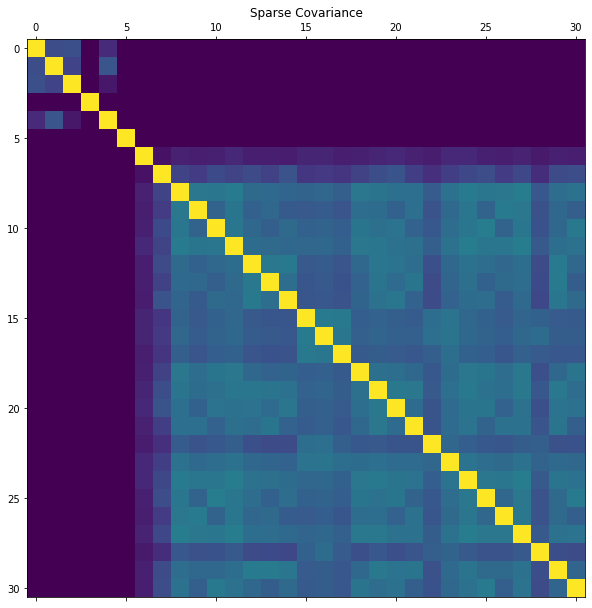

In [39]:
plt.matshow(edge_model.covariance_)
plt.title("Sparse Covariance")

In the two matrices above you can clearly see the differences. Much of the second matrix is zero, but the first one has a mix of near-zero values. The Graphical Lasso shows us which connections are the most important. Note that the diagonal elements no longer represent each tickers individual variance, but we don't need that anyways.

# Clustering

Okay so we have a matrix that tells us which ETFs are structurally related, so we can move the estimating clusters. I'm going to use Affinity Propogation for this because of two reasons: it selects the number of clusters automatically, and it provides a member of each cluster that best represents it. The latter reason is the coolest feature of this method. After it finds out which ETFs belong to which cluster, it will tell us which one of them best represents each cluster. This is exactly what we want! I don't want to deal with 31 different ETFs, I want to deal with a small number that best represents the whole group. This is essentially a dimensionality reduction problem.

I'm using a slightly smaller preference value than sklearn would use because I want the number of cluster to be smaller. This is a flexible value. Sklearn by default sets it as the median of the affinity matrix, in this case the covariance matrix. If you set it smaller, there will be fewer clusters, and bigger means more clusters.

In [128]:
clustering = AffinityPropagation(affinity="precomputed", preference=0.15).fit(edge_model.covariance_)

/home/eadains/EquitiesTrading/venv/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [138]:
n_labels = clustering.labels_.max()
cluster_centers = returns.columns[clustering.cluster_centers_indices_]

for i in range(n_labels + 1):
    print(f"Cluster {i+1}: {', '.join(returns.columns[clustering.labels_ == i])}")
    print(f"    Cluster Representative: {cluster_centers[i]}")
    print("\n")

Cluster 1: BIV, BLV, BND, EDV
    Cluster Representative: BLV


Cluster 2: BSV
    Cluster Representative: BSV


Cluster 3: EMB
    Cluster Representative: EMB


Cluster 4: HYG
    Cluster Representative: HYG


Cluster 5: VEA, VEU, VGK, VPL, VT, VWO
    Cluster Representative: VEU


Cluster 6: IYR, MGC, MGK, MGV, SPY, VB, VBK, VBR, VIG, VO, VOE, VOT, VTI, VTV, VUG, VV, VXF, VYM
    Cluster Representative: VTI




Okay, so we get 6 clusters from our 31 ETFs. Looking at them qualitiatively, it matches with our expectations. Cluster 1 is longer term bonds, cluster 5 is non-US equities, and cluster 6 is US equities. Looking at which are selected as being representative, we get a very intuitive answer: long term bonds, short term bonds, emerging market bonds, junk bonds, non-US equities, and US total stock market. One slightly unexpected grouping is that real estate (IYR) is grouped with equities.

# Visualization

For some extra fun, how do we visualize this? We have the concept of clusters being things that are close together in space, but in this case, what does space even mean? It's very high-dimensional and non-intuitive. Well, luckily there is a way to attempt to embed higher-dimensional space into lower-dimensional space called Manifold learning. This method tries to find a way in two-dimensions to best represent patterns and groupings in higher-dimensions.

In [132]:
embed = LocallyLinearEmbedding(n_neighbors=10, n_components=2)
embed = embed.fit_transform(edge_model.covariance_)

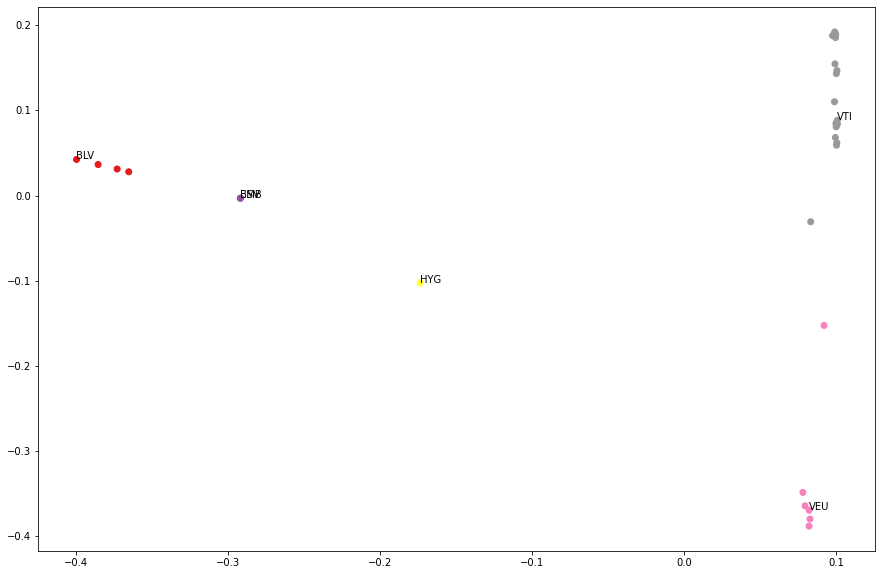

In [133]:
plt.scatter(embed[:, 0], embed[:, 1], c=clustering.labels_, cmap="Set1")

labels = returns.columns[clustering.cluster_centers_indices_]
points = embed[clustering.cluster_centers_indices_]
for i, label in enumerate(labels):
    plt.annotate(label, (points[i, 0], points[i, 1]))

So, here we can see each of our clusters color-coded with the representative ETF from each cluster labeled. You can obviously see the clustering: bonds in red on the left, non-US equities pink on the bottom right, and US equities in grey in the upper right. Note the overlaid text between EMB and BSV on the left-hand side. The clustering algothihm views them as being distinct, but they are right on top of each other in this 2d embedding. This most likely means there is some high-dimensional difference between them that cannot be projected downward into 2 dimensions.

# Conclusion

This is way a casual look into clustering applied to ETFs. There's a lot more you can do with this. There are more sophiscated estimation methods that are potentially non-linear, and you can obviously greatly expand the number of tickers under analysis. This can also be applied to groups of stocks, which can be useful for finding pairs trades.